# Modelling and Evaluation

### Inputs
- Train set engineered CSV

### Outputs

### Objectives

- Select best hyperparameters and algorithm
- Predict CSmpA of concrete via regression

In [1]:
import os
current_dir = os.getcwd()
current_dir


'/workspace/concrete-strength/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/concrete-strength'

Load data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/DatasetEngineered.csv"))
print(df.shape)
df.head()

(1030, 8)


,cement,slag,flyash,water,coarseaggregate,fineaggregate,age,csMPa
0,11.138686,0.692662,1.0,74.797774,2269.592565,83874.646831,3.377358,43.89
1,11.138686,0.692662,1.0,74.797774,2306.547918,83874.646831,3.377358,38.21
2,9.813326,4.948381,1.0,98.669830,2005.603189,66232.900982,5.630006,33.42
3,9.813326,4.948381,1.0,98.669830,2005.603189,66232.900982,5.933598,13.12
4,8.520842,4.876641,1.0,85.841906,2118.561303,120826.246384,5.919698,47.22


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['csMPa'], axis=1), df['csMPa'], test_size = 0.20, random_state = 37)

In [13]:
X_train.dtypes

cement             float64
slag               float64
flyash             float64
water              float64
coarseaggregate    float64
fineaggregate      float64
age                float64
dtype: object

Create pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([ ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model)])
    
    return pipeline_base

Hyperparameter optimisation search

In [10]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))
            
            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In [11]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [12]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/pipeline.py", line 348, in 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [17]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
5,XGBRegressor,0.806251,0.891416,0.92914,0.045315,0.05,1000
7,XGBRegressor,0.812234,0.891128,0.930359,0.042984,0.1,500
8,XGBRegressor,0.811054,0.890798,0.929841,0.043384,0.1,1000
4,XGBRegressor,0.804569,0.890581,0.927162,0.045144,0.05,500
6,XGBRegressor,0.797791,0.884057,0.920911,0.045306,0.1,100
2,XGBRegressor,0.791391,0.884002,0.920423,0.048008,0.01,1000
3,XGBRegressor,0.766132,0.868882,0.911165,0.053185,0.05,100
1,XGBRegressor,0.76554,0.868712,0.910495,0.053385,0.01,500
0,XGBRegressor,-0.114944,0.019915,0.16747,0.115819,0.01,100


Extensive search on most suitable model - https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [15]:
models_search = {
    "XGBRegressor": XGBRegressor(random_state=0)
}

params_search = {
    "XGBRegressor": {
        #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.6, 0.8, 1.0],
        #'colsample_bytree': [0.6, 0.8, 1.0],
        #'max_depth': [3, 4, 5],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__n_estimators': [100, 500, 1000]
    }
}

In [16]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(features, target, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
5,XGBRegressor,0.806251,0.891416,0.92914,0.045315,0.05,1000
7,XGBRegressor,0.812234,0.891128,0.930359,0.042984,0.1,500
8,XGBRegressor,0.811054,0.890798,0.929841,0.043384,0.1,1000
4,XGBRegressor,0.804569,0.890581,0.927162,0.045144,0.05,500
6,XGBRegressor,0.797791,0.884057,0.920911,0.045306,0.1,100
2,XGBRegressor,0.791391,0.884002,0.920423,0.048008,0.01,1000
3,XGBRegressor,0.766132,0.868882,0.911165,0.053185,0.05,100
1,XGBRegressor,0.76554,0.868712,0.910495,0.053385,0.01,500
0,XGBRegressor,-0.114944,0.019915,0.16747,0.115819,0.01,100


Best params for mean R2 Score

In [9]:
params_search = {'XGBRegressor': {
    'model__learning_rate': [0.05],
    'model__n_estimators': [1000]
}}

Fit model with best parameters

In [10]:
xgbr = XGBRegressor(learning_rate=0.05, n_estimators=1000, verbosity=1)
pipeline_xgbr = PipelineOptimization(xgbr)

In [11]:
pipeline_xgbr.fit(features, target)

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBRegressor(base_score=0.5,
                                                        booster='gbtree',
                                                        callbacks=None,
                                                        colsample_bylevel=1,
                                                        colsample_bynode=1,
                                                        colsample_bytree=1,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=0, gpu_id=-1,
                                                        grow_policy='depth

In [12]:
score = pipeline_xgbr.score(features, target)
print("Training score: ", score)

Training score:  0.9930592791360722


5-Fold and K-Fold Cross validation

In [14]:
from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(pipeline_xgbr, features, target, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(pipeline_xgbr, features, target, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

KeyboardInterrupt: 

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [26]:
test_target

0      26.06
1      10.35
2      79.30
3      74.99
4       9.69
       ...  
201    27.53
202    33.76
203    33.01
204    33.72
205    13.82
Name: csMPa, Length: 206, dtype: float64

In [22]:
pipeline_xgbr.predict(test_features)

array([48.419697, 22.797981, 71.18165 , 61.38392 , 28.538818, 54.540703,
       61.410988, 52.361046, 61.38392 , 72.91608 , 61.38392 , 63.43401 ,
       70.68177 , 46.829136, 61.38392 , 71.08641 , 61.682606, 71.84898 ,
       55.411312, 61.38392 , 71.08641 , 72.83964 , 48.19262 , 48.419697,
       55.411312, 61.38392 , 61.410988, 52.361046, 71.08641 , 71.18165 ,
       61.38392 , 71.84898 , 52.55182 , 61.410988, 55.411312, 33.139767,
       46.781834, 61.682606, 48.6924  , 51.678005, 46.781834, 71.84898 ,
       61.38392 , 47.207783, 61.38392 , 46.781834, 55.411312, 48.419697,
       53.790184, 68.95166 , 61.410988, 61.38392 , 43.9412  , 71.58333 ,
       60.572945, 61.38392 , 61.838226, 61.66407 , 70.6894  , 71.08641 ,
       61.38392 , 61.682606, 61.66407 , 54.540703, 39.26965 , 61.319534,
       61.410988, 36.470882, 39.833942, 55.411312, 32.511593, 53.94354 ,
       54.540703, 61.38392 , 61.410988, 46.898144, 61.410988, 46.781834,
       61.38392 , 70.68177 , 55.411312, 71.58333 , 

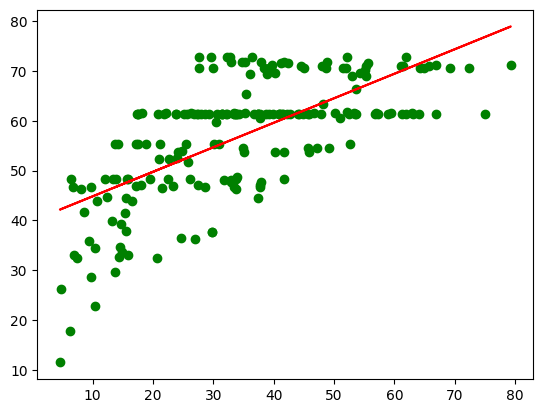

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(test_target, pipeline_xgbr.predict(test_features), 'o', color='green')
m, b = np.polyfit(test_target, pipeline_xgbr.predict(test_features), 1)
plt.plot(test_target, m*test_target+b, color='red')

In [25]:
from sklearn import metrics
metrics.r2_score(test_target, pipeline_xgbr.predict(test_features))

-1.4517935891016083

In [9]:
import joblib
import os
version = 'v1'
file_path = f'outputs/ml_pipeline/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/v1'


In [17]:

joblib.dump(value=pipeline_xgbr, 
filename=f'{file_path}/regression_model.pkl')

['outputs/ml_pipeline/v1/regression_model.pkl']

In [16]:
import pickle
PFILE = f'{file_path}/regression_model.pkl'
def read_from_pickle(p):
      with open(p, 'rb') as f:
        yield pickle.load(f)


In [18]:
regressor_model = read_from_pickle(PFILE)

In [19]:
regressor_model.predict(test_features)

AttributeError: 'generator' object has no attribute 'predict'